In [117]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import fcwt
from pydub import AudioSegment

# Load the audio file (modify the path as needed)
file_path = "Fiddle.wav"
sample_rate, audio_data = wav.read(file_path)
audio_data = audio_data[::4]
sample_rate = sample_rate/4
# Ensure the audio is mono
if len(audio_data.shape) > 1:
    audio_data = audio_data[:, 0]

# Define parameters
fs = 8000  # Sampling frequency (Hz)
duration = 20  # Duration of audio clip (s)
total_samples = fs * duration

C:\Users\24261951\AppData\Local\Temp\ipykernel_1264\3809810873.py:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = wav.read(file_path)


In [118]:
fft_plotter('Fiddle.wav',xlim = 6000,filter = False)
fft_plotter('Fiddle.wav')

NameError: name 'fft_plotter' is not defined

In [ ]:
def bandpass_filter(x, fs, f_low, f_high):
    return


In [124]:
def fcwt_custom_plotter(audio_data,sample_rate,filter = False):

    #make sure signal is a numpy float array
    signal = np.array(audio_data, dtype=np.float32)
    if filter:
        signal = np.float32(bandpass_filter(signal,200,1100,sample_rate))
    #signal = signal[::4]
    #sample_rate = sample_rate/4

    fn = 100
    f0 = 200
    f1 = 2500
    #initialize Morlet wavelet with wavelet parameter (sigma) 2.0
    morl = fcwt.Morlet(2.0)
    #initialize scales
    scales = fcwt.Scales(morl, fcwt.FCWT_LINFREQS, fs, f0, f1, fn)

    #initialize fcwt
    nthreads = 4
    use_optimization_plan = False
    use_normalization = True
    fcwt_obj = fcwt.FCWT(morl, nthreads, use_optimization_plan, use_normalization)

    #initialize output array
    output = np.zeros((fn,signal.size), dtype=np.complex64)

    #calculate cwt
    fcwt_obj.cwt(signal, scales, output)
    output = np.abs(output) ** 2

    #plot cwt
    plt.imshow(np.abs(output),aspect='auto')
    plt.show()
    return np.abs(output)

In [176]:
def fcwtplotter(audio_data,sample_rate,filter = True):
    #make sure signal is a numpy float array
    audio_data = np.array(audio_data, dtype=np.float32)
    audio_data -= np.mean(audio_data)
    # 2. Divide by the maximum absolute value to scale between -1 and 1
    max_val = np.max(np.abs(audio_data))
    if max_val > 0:
        signal = audio_data / max_val


    fn = 100
    f0 = 200
    f1 = 2500
    fcwt.plot(signal, sample_rate, f0=f0, f1=f1, fn=fn)


In [196]:
def cross_wavelet(signal1, signal2,frame_rate):
    highest = 1100
    freqs, coeffs1 = fcwt.cwt(signal1,frame_rate,200,highest,200,nthreads = 4)
    _, coeffs2 = fcwt.cwt(signal2,frame_rate,200,highest,200,nthreads = 4)

    S12 = coeffs1 * (coeffs2)
    return np.abs(S12),freqs,_

In [201]:
import numpy as np
from pycwt import wct
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import scipy.io.wavfile as wav
# Compute the wavelet coherence
def wavelet_coherence(signal1, signal2,frame_rate):
    highest = 1100
    freqs, coeffs1 = fcwt.cwt(signal1,frame_rate,200,highest,200,nthreads = 4)
    _, coeffs2 = fcwt.cwt(signal2,frame_rate,200,highest,200,nthreads = 4)

    # Compute coherence
    S1 = np.abs(coeffs1) ** 2
    S2 = np.abs(coeffs2) ** 2
    S12 = coeffs1 * np.conj(coeffs2)
    
    # Smooth spectra and cross-spectrum
    def smooth(data, sigma=(2,2), mode='nearest'):
        return gaussian_filter(data, sigma=sigma, mode=mode)

    S1_smoothed = smooth(S1)
    S2_smoothed = smooth(S2)
    S12_smoothed = smooth(np.abs(S12) ** 2)

    # Coherence calculation
    #coherence = S12_smoothed / (((S1_smoothed) **2) * ((S2_smoothed)**2))
    coherence = S12_smoothed / (np.sqrt(S1_smoothed) * np.sqrt(S2_smoothed))
    #coherence = np.clip(coherence, 0.0, 1.0)  # Limit coherence to [0, 1]

    return coherence, freqs, [coeffs1,coeffs2]


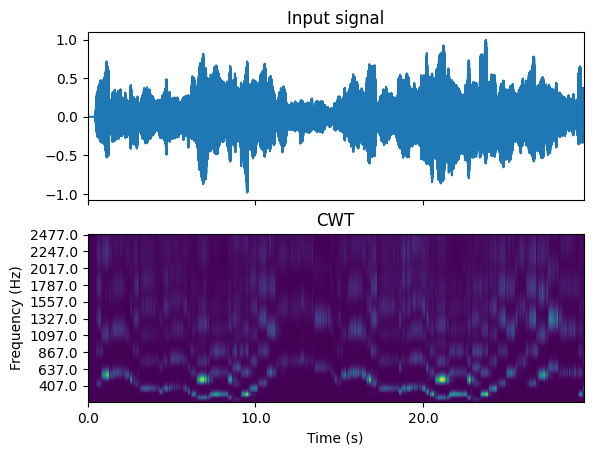

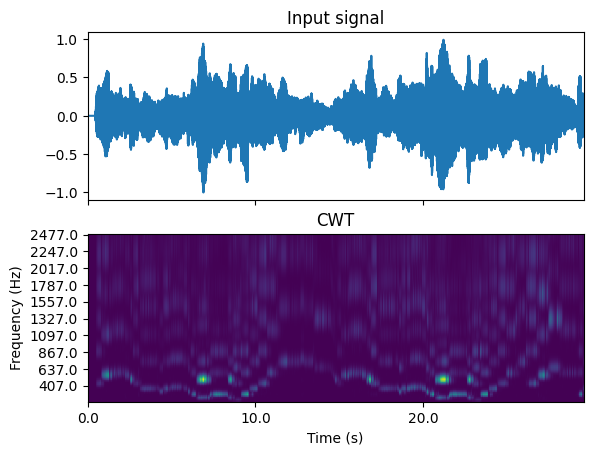

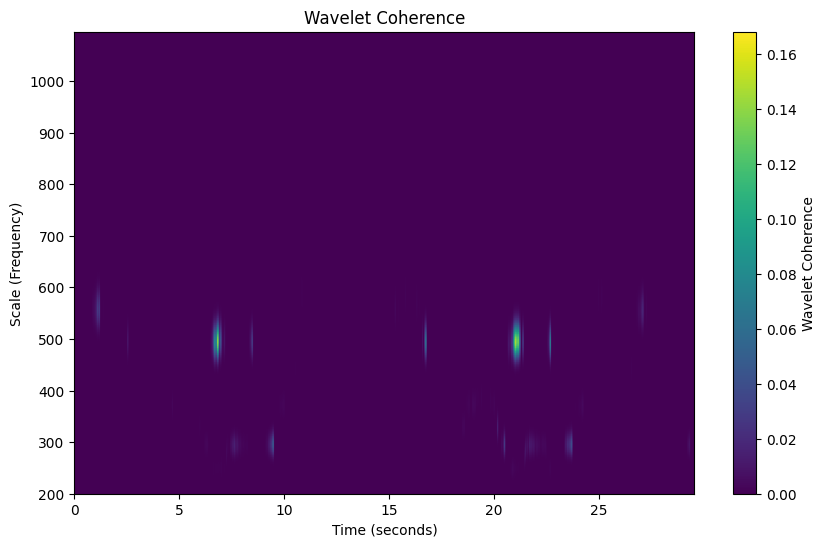

In [202]:
def coherence_plot(data1,data2,frame_rate):
    audio_data1 = np.array(data1, dtype=np.float32)
    audio_data1 -= np.mean(audio_data1)
    # 2. Divide by the maximum absolute value to scale between -1 and 1
    max1 = np.max(np.abs(audio_data1))
    if max1 > 0:
        data1 = audio_data1 / max1
    audio_data2 = np.array(data2, dtype=np.float32)
    audio_data2 -= np.mean(audio_data2)
    # 2. Divide by the maximum absolute value to scale between -1 and 1
    max2 = np.max(np.abs(audio_data2))
    if max2 > 0:
        data2 = audio_data2 / max2
    fcwtplotter(data1,frame_rate,filter = False)
    fcwtplotter(data2,frame_rate,filter = False)
    coherence, freqs, coeffs = wavelet_coherence(data1, data2, frame_rate)
    plt.figure(figsize=(10, 6))
    plt.imshow(coherence, aspect='auto', extent=[0, len(coherence[0])/frame_rate, freqs[-1], freqs[0]])
    plt.colorbar(label='Wavelet Coherence')
    plt.ylabel('Scale (Frequency)')
    plt.xlabel('Time (seconds)')
    plt.title('Wavelet Coherence')
    plt.show()

frame_rate = 8000
data1 = AudioSegment.from_wav('af_left.wav').set_frame_rate(frame_rate).split_to_mono()[0]
data2 = AudioSegment.from_wav('af_right.wav').set_frame_rate(frame_rate).split_to_mono()[1]
data1 = np.frombuffer(data1.raw_data,np.int16)
data2 = np.frombuffer(data2.raw_data,np.int16)
#frame_rate = data1.frame_rate
coherence_plot(data1,data2,frame_rate)


<Figure size 1000x600 with 0 Axes>

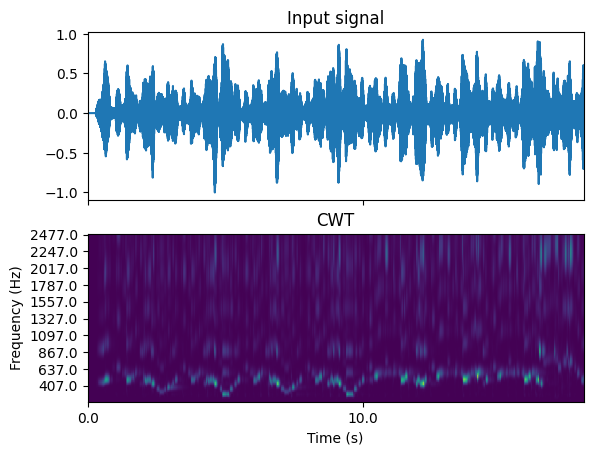

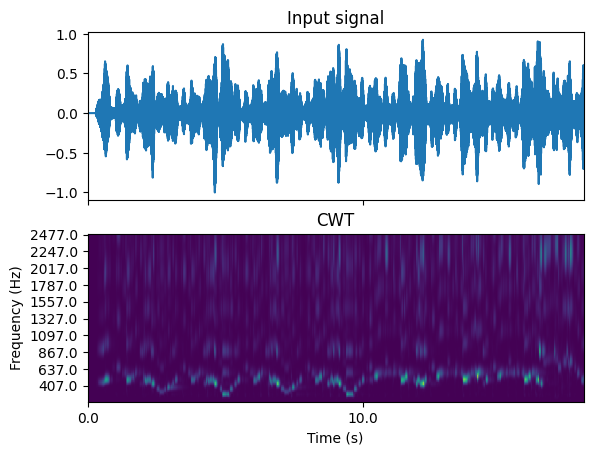

C:\Users\24261951\AppData\Local\Temp\ipykernel_1264\4183314174.py:26: RuntimeWarning: divide by zero encountered in divide
  coherence = S12_smoothed / (((S1_smoothed) **2) * ((S2_smoothed)**2))


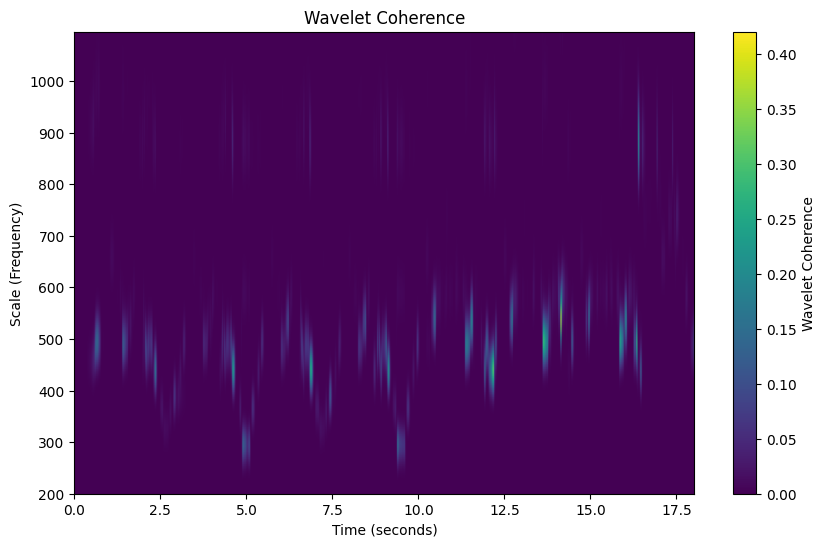

In [181]:
plt.figure(figsize=(10, 6))
frame_rate = 8000
data1 = AudioSegment.from_wav('kerry_reel_burke.wav').set_frame_rate(frame_rate)
data2 = AudioSegment.from_wav('kerry_reel_haige.wav').set_frame_rate(frame_rate)
data1 = np.frombuffer(data1.raw_data,np.int16)
data2 = np.frombuffer(data2.raw_data,np.int16)
coherence_plot(data1,data1,frame_rate)

In [171]:
sd.play(data2,8000)


In [155]:
sd.stop()

In [ ]:
from scipy.signal import butter, filtfilt

# Bandpass filter function
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal